# GA Project 4: West Nile Virus
by: Nicholas Lim, Kwek Jun Hong, Malcolm Lau
***

## Notebook organisation
- Notebook 1: Data Cleaning, EDA and Feature Engineering 
- **Notebook 2: Model Tuning, Evaluation and Cost Benefit Analysis (current notebook)**


# Imports

In [1]:
# fabulous four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix , plot_roc_curve
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnpipe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# etc
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
train = pd.read_csv('data/train_cleaned.csv')
train.head()

,date,latitude,longitude,wnv_present,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHERS
0,2007-05-29,41.954690,-87.800991,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615,1,0,0
1,2007-05-29,41.954690,-87.800991,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615,0,1,0
2,2007-05-29,41.994991,-87.769279,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615,0,1,0
3,2007-05-29,41.974089,-87.824812,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615,1,0,0
4,2007-05-29,41.974089,-87.824812,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615,0,1,0


We will be creating a copy of the `test` dataset for modeling and kaggle submission purposes, the original dataset will be used for the [cost-benefit analysis](#Cost-Benefit-Analysis).

In [3]:
test = pd.read_csv('data/test_cleaned.csv')
test_kaggle= test.copy()

# Modeling
***
The following models would be used:

|                |                  Models                 |
|:--------------:|:---------------------------------------:|
| Baseline Model |               BernoulliNB               |
|     Model 1    |            Logistic Regression          |
|     Model 2    |          Random Forest Classifier       |
|     Model 3    |        Gradient Boosting Classifier     |
|     Model 4    |              XGBoost Classifier         |

As we have an unbalanced classification problem, we will be using SMOTE to oversample the data to address the imbalance in the data through a pipeline and running the models afterwards. The choices of the models are a mix of tree based models and a linear model to see which model would perform the best.

## Model data preparation

### Get the X, y data

In [4]:
X = train.drop(['date', 'wnv_present'], axis = 1)
y = train['wnv_present']

In [5]:
print(X.shape)
print(y.shape)

(10506, 15)
(10506,)


In [6]:
y.value_counts(normalize = True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

### Train, test, split the data

In [7]:
X.columns

Index(['latitude', 'longitude', 'tavg', 'dew_point', 'precip_total',
       'stn_pressure', 'avg_speed', 'year', 'month', 'week_of_year',
       'daylight_hours', 'r_humidity', 'species_CULEX PIPIENS/RESTUANS',
       'species_CULEX RESTUANS', 'species_OTHERS'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7879, 15)
(2627, 15)
(7879,)
(2627,)


## Modeling Functions

In [10]:
# define the numerical columns

numerical_cols = [
    "latitude",
    "longitude",
    "tavg",
    "dew_point",
    "precip_total",
    "stn_pressure",
    "avg_speed",
    "daylight_hours",
    "r_humidity",
    "year",
    "month",
    "week_of_year",
]

In [11]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()


# Bundle preprocessing for numerical and categorical data
transformer = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numerical_cols)
    ]
)

In [12]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input column transformer and model
def run_model(X_train, X_test, y_train, y_test, mod, mod_params={}, grid_search=False):

    # Initial dictionary to hold model results
    results = {}

    pipe = imblearnpipe(
        [("t", transformer), ("sampling", SMOTE(random_state=42)), (mod, models[mod])]
    )

    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(
            pipe, param_grid=mod_params, cv=5, verbose=1, scoring="roc_auc", n_jobs=-2
        )
        gs.fit(X_train, y_train)
        pipe = gs

    else:
        pipe.fit(X_train, y_train)

    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, predictions),
        index=["Actual Negative", "Actual Postive"],
        columns=["Predicted Negative", "Predicted Postive"],
    )
    y_test_pred_prob = pipe.predict_proba(X_test)[:, 1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:, 1]

    results["model"] = mod
    results["train_auc"] = round(roc_auc_score(y_train, y_train_pred_prob), 3)
    results["test_auc"] = round(roc_auc_score(y_test, y_test_pred_prob), 3)
    results["precision"] = round(precision_score(y_test, predictions), 3)
    results["specificity"] = round(tn / (tn + fp), 3)
    results["recall"] = round(recall_score(y_test, predictions), 3)
    results["f_score"] = round(f1_score(y_test, predictions), 3)
    if grid_search:
        results['best score'] = round(pipe.best_score_, 3)

    if grid_search:
        gs_list.append(results)
        print("---Best Parameters---")
        display(pipe.best_params_)

    else:
        init_list.append(results)

    print("Model:", models[mod])
    print("---Model Metrics---")
    display(results)
    display(cm_df)
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")

    print()
    return pipe

In [13]:
def features_plot_lr(mod, title, X=X_train):
    """Function to plot feature importance from models"""
    col = mod.best_estimator_.steps[0][1].get_feature_names_out()
    impt = mod.best_estimator_.steps[2][1].coef_.ravel()

    temp_df = pd.DataFrame(index=col, data = impt, columns = ['features'])
    temp_df.sort_values(by='features').plot(kind='barh', figsize=(16,9))
    plt.title(f'Feature Importance from {title}');

In [14]:
def features_plot(mod, title, X=X_train):
    """Function to plot feature importance from models"""
    col = mod.best_estimator_.steps[0][1].get_feature_names_out()
    impt = mod.best_estimator_.steps[2][1].feature_importances_

    temp_df = pd.DataFrame(index=col, data=impt, columns=['features'])
    temp_df.sort_values(by='features').plot(kind='barh' , figsize=(16,9))
    plt.title(f'Feature Importance from {title}');

## Model Tuning


In [15]:
# Instantiate the models
models = {
    "nb": BernoulliNB(),
    "lr": LogisticRegression(),
    "rf": RandomForestClassifier(random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "xgb": XGBClassifier(
        objective="binary:logistic", random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
}

### Baseline Model

We will be using Bernoulli Naive Bayes as our baseline model as we are working with a binary classification problem.

In [16]:
%time nb = run_model(X_train, X_test, y_train, y_test, 'nb')

Model: BernoulliNB()
---Model Metrics---


{'model': 'nb',
 'train_auc': 0.744,
 'test_auc': 0.721,
 'precision': 0.086,
 'specificity': 0.57,
 'recall': 0.732,
 'f_score': 0.154}

,Predicted Negative,Predicted Postive
Actual Negative,1419,1070
Actual Postive,37,101


True Negatives: 1419
False Negatives: 37
True Positives: 101
False Positives: 1070

Wall time: 65 ms


As we can see, there are many false positives with a low precision, which can be expected from heavily imbalanced classes. This also leads to a low F1 score as a result. Hopefully this score can be improved with different models and the SMOTE technique.

### Candidate Models Tuning

#### Logistic Regression

In [17]:
lr_params = {'sampling__sampling_strategy': ['auto'], # ['minority', 'auto']
             'sampling__k_neighbors': [7, 8, 9], # [4, 5, 6, 7, 8, 9]
             'lr__penalty' : ['l1'], #['l1', 'l2']
             'lr__max_iter' : [5000],
             'lr__solver' : ['saga'], # ['liblinear', 'saga']
             'lr__C' : [0.4, 0.6, 0.8], # [0.4, 0.6, 0.8, 1.0, 1.2]
             'lr__class_weight' : ['balanced'] # [None, 'balanced']
            }

In [18]:
%time lr = run_model(X_train, X_test, y_train, y_test, 'lr', lr_params, grid_search = True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
---Best Parameters---


{'lr__C': 0.4,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 5000,
 'lr__penalty': 'l1',
 'lr__solver': 'saga',
 'sampling__k_neighbors': 7,
 'sampling__sampling_strategy': 'auto'}

Model: LogisticRegression()
---Model Metrics---


{'model': 'lr',
 'train_auc': 0.773,
 'test_auc': 0.782,
 'precision': 0.112,
 'specificity': 0.657,
 'recall': 0.783,
 'f_score': 0.197,
 'best score': 0.769}

,Predicted Negative,Predicted Postive
Actual Negative,1636,853
Actual Postive,30,108


True Negatives: 1636
False Negatives: 30
True Positives: 108
False Positives: 853

Wall time: 3.85 s


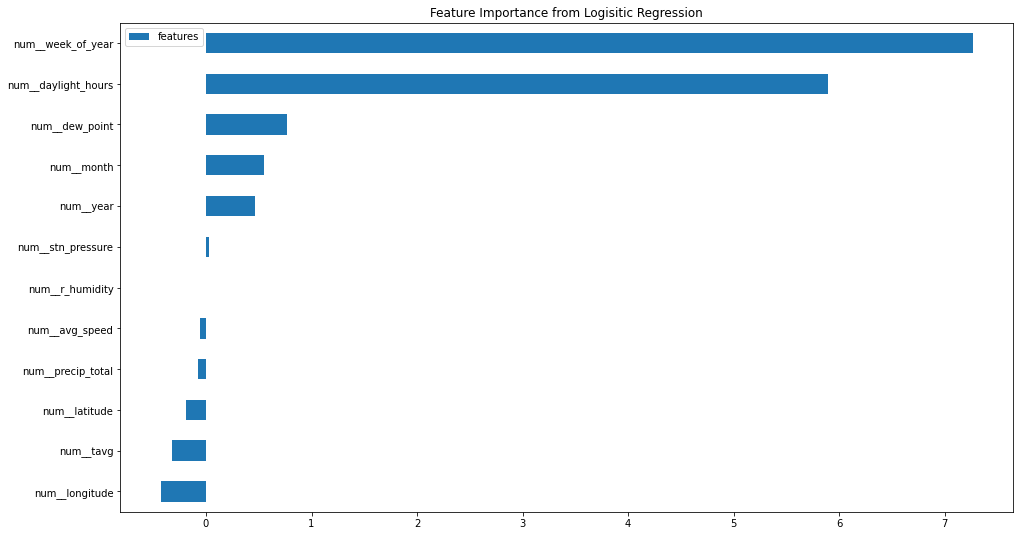

In [19]:
features_plot_lr(lr, 'Logisitic Regression')

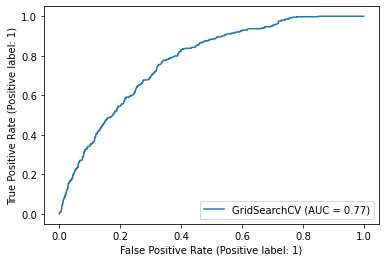

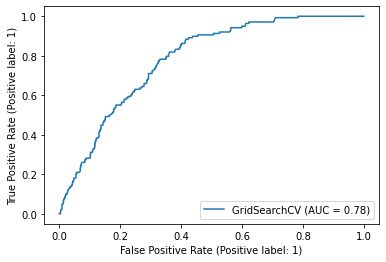

In [20]:
# plot the AUC ROC curve
plot_roc_curve(lr, X_train, y_train)
plot_roc_curve(lr, X_test, y_test);

#### Random Forest

In [21]:
rf_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
             'sampling__k_neighbors': [5],  # [4, 5, 6]
             'rf__n_estimators': [200], # [50, 100, 150, 200, 250, 300]
             'rf__min_samples_split' : [2], # [2, 4, 6, 8]
             'rf__max_depth': [9], # [5, 7, 9, 11, 13, 15]
             'rf__min_samples_leaf': [7], # [3, 5, 7, 8, 9]]
             'rf__class_weight' : ['balanced'] # ['balanced', 'balanced_subsample']
            }

In [22]:
%time rf = run_model(X_train, X_test, y_train, y_test, 'rf', rf_params, grid_search=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'rf__class_weight': 'balanced',
 'rf__max_depth': 9,
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority'}

Model: RandomForestClassifier(random_state=42)
---Model Metrics---


{'model': 'rf',
 'train_auc': 0.89,
 'test_auc': 0.817,
 'precision': 0.147,
 'specificity': 0.8,
 'recall': 0.623,
 'f_score': 0.238,
 'best score': 0.832}

,Predicted Negative,Predicted Postive
Actual Negative,1990,499
Actual Postive,52,86


True Negatives: 1990
False Negatives: 52
True Positives: 86
False Positives: 499

Wall time: 2.75 s


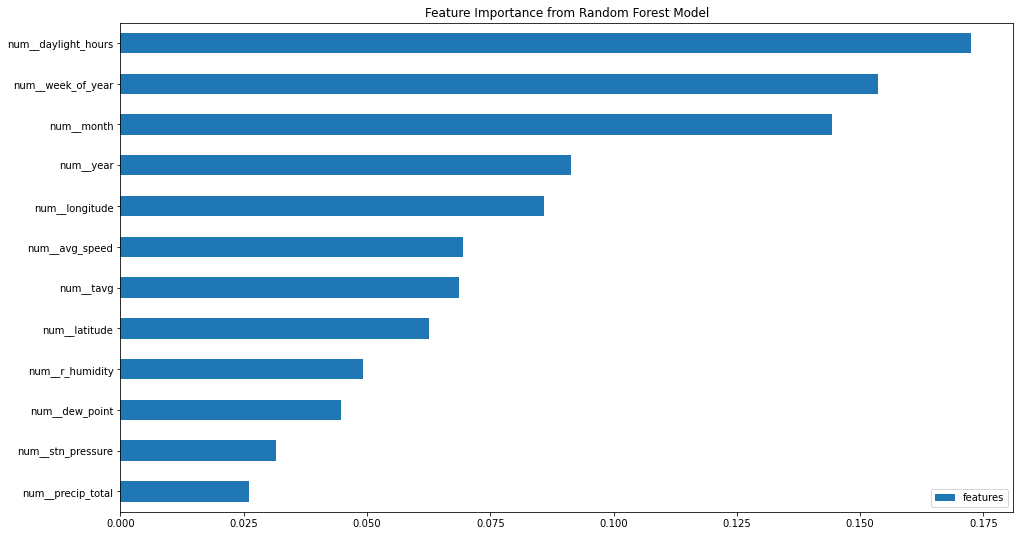

In [23]:
features_plot(rf, 'Random Forest Model')

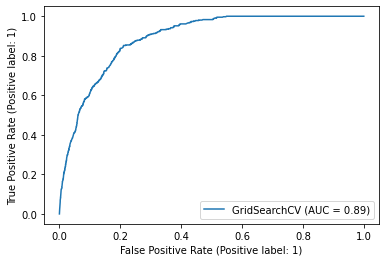

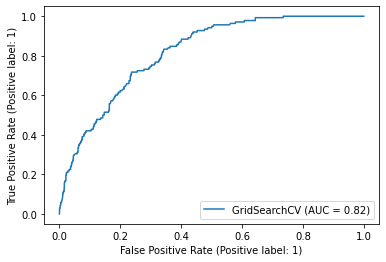

In [24]:
# plot the AUC ROC curve
plot_roc_curve(rf, X_train, y_train)
plot_roc_curve(rf, X_test, y_test);

#### Gradient Boosting Classifier

In [25]:
gb_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
             'sampling__k_neighbors': [5], # [4, 5, 6]
             'gb__max_depth': [4], # [2, 3, 4, 5]
             'gb__n_estimators': [100], # [50, 100, 150, 200]
             'gb__min_samples_leaf': [1], # [1, 3, 5]
             'gb__learning_rate': [.15] # [.08, .1, .13, .15, .17]
            }

In [26]:
%time gb = run_model(X_train, X_test, y_train, y_test, 'gb', gb_params, grid_search=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'gb__learning_rate': 0.15,
 'gb__max_depth': 4,
 'gb__min_samples_leaf': 1,
 'gb__n_estimators': 100,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority'}

Model: GradientBoostingClassifier(random_state=42)
---Model Metrics---


{'model': 'gb',
 'train_auc': 0.891,
 'test_auc': 0.808,
 'precision': 0.161,
 'specificity': 0.843,
 'recall': 0.543,
 'f_score': 0.249,
 'best score': 0.828}

,Predicted Negative,Predicted Postive
Actual Negative,2099,390
Actual Postive,63,75


True Negatives: 2099
False Negatives: 63
True Positives: 75
False Positives: 390

Wall time: 3.22 s


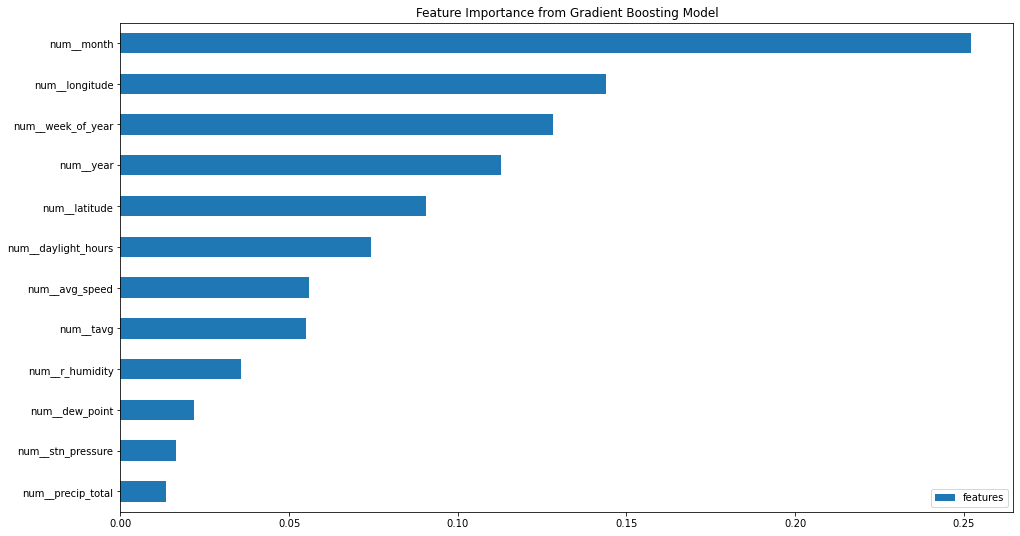

In [27]:
features_plot(gb, 'Gradient Boosting Model')

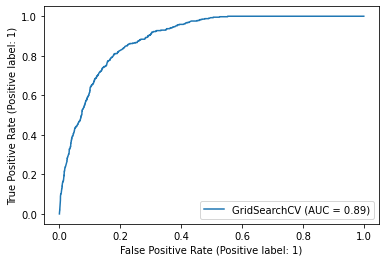

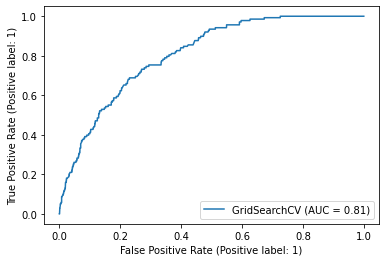

In [28]:
# plot the AUC ROC curve
plot_roc_curve(gb, X_train, y_train)
plot_roc_curve(gb, X_test, y_test);

#### XGBoost Classifier

In [29]:
xgb_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
              'sampling__k_neighbors': [4], #[2, 3, 4, 5, 6]
              'xgb__max_depth' : [4], # [2, 3, 4, 6, 8]
              'xgb__gamma' : [0], # [0 , 0.01 , 0.05]
              'xgb__learning_rate' : [0.1], # [.05, 0.1, 0.2, 0.3, 0.4]
              'xgb__n_estimators' : [40], # [20, 40, 60, 80, 100]
              'xgb__subsample' : [0.5], # [0.3, 0.5, 1]
              'xgb__colsample_bytree' : [1], # [0.5, 1]
              'xgb__lambda' : [0.5], # [0.1, 0.3, 0.5, 1, 5]
              'xgb__alpha' : [0.5] # [0, 0.5, 1]
             }

In [30]:
%time xgb = run_model(X_train, X_test, y_train, y_test, 'xgb', xgb_params, grid_search=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'sampling__k_neighbors': 4,
 'sampling__sampling_strategy': 'minority',
 'xgb__alpha': 0.5,
 'xgb__colsample_bytree': 1,
 'xgb__gamma': 0,
 'xgb__lambda': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 40,
 'xgb__subsample': 0.5}

Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
---Model Metrics---


{'model': 'xgb',
 'train_auc': 0.873,
 'test_auc': 0.823,
 'precision': 0.143,
 'specificity': 0.752,
 'recall': 0.746,
 'f_score': 0.24,
 'best score': 0.833}

,Predicted Negative,Predicted Postive
Actual Negative,1872,617
Actual Postive,35,103


True Negatives: 1872
False Negatives: 35
True Positives: 103
False Positives: 617

Wall time: 1.1 s


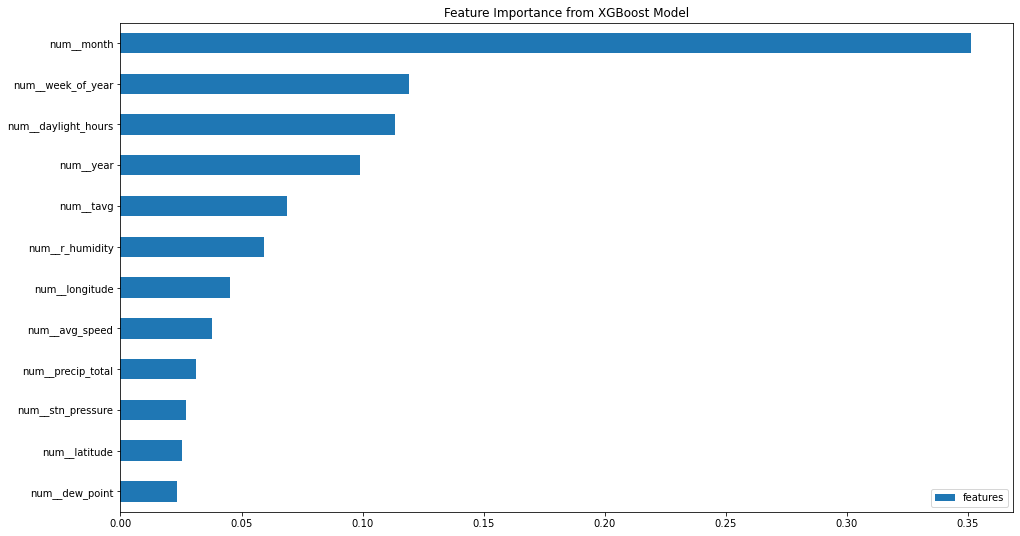

In [31]:
features_plot(xgb, 'XGBoost Model')

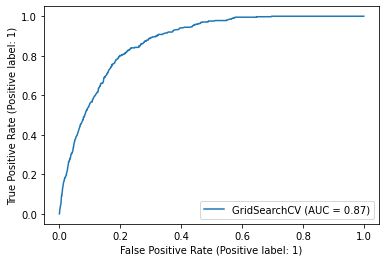

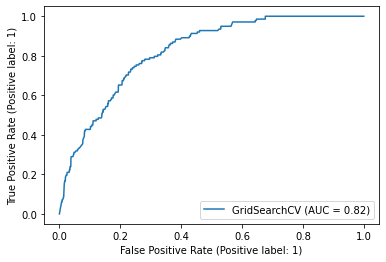

In [32]:
# plot the AUC ROC curve
plot_roc_curve(xgb, X_train, y_train)
plot_roc_curve(xgb, X_test, y_test);

### Plotting the ROC AUC Curves

In [33]:
def plot_roc_curves(model_dict, plot_top=False):
    """Function to plot all the ROC AUC curves of the models"""
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curves Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=12)

In [34]:
# define a dictionary of the models for use in the function
test_models = {
    lr: "Logistic Regression",
    rf: "Random Forest Classifier",
    gb: "Gradient Boosting Classifier",
    xgb: "XGB Classifier",
}

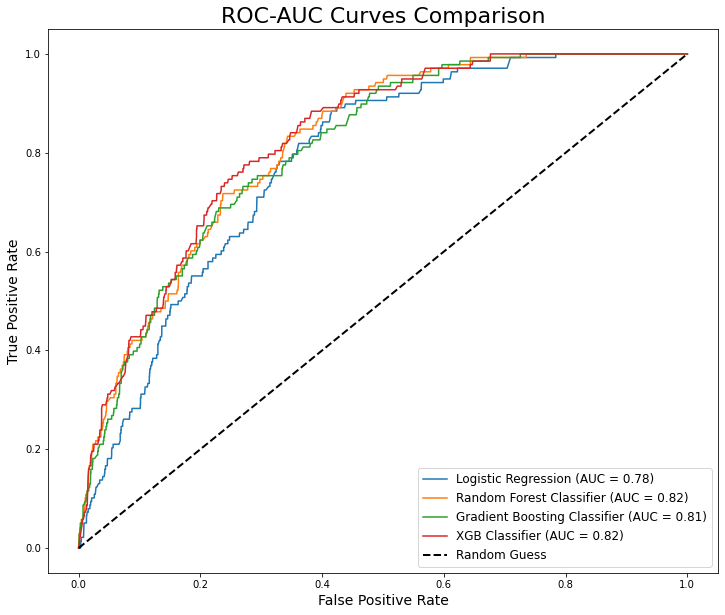

In [35]:
# plot the ROC-AUC curves of all the models
plot_roc_curves(test_models)

As seen from the ROC AUC curve, the logisitic regression model performed the worst out of all the models and the other three tree based models have roughly the same AUC score of 0.82 to 0.83. 

# Model Evaluation

**Summary of Results**

|                |            Models            | Train AUC | Test AUC | F-score |Gridsearch AUC |
|:--------------:|:----------------------------:|:---------:|:--------:|:-------:|:---------:    |
| Baseline Model |          BernoulliNB         |   0.744   |   0.721  |  0.154  |    NA     |
|     Model 1    |      Logistic Regression     |   0.773   |   0.782  |  0.197  |   0.769   |
|     Model 2    |   Random Forest Classifier   |   0.890   |   0.817  |  0.238  |   0.832   |
|     Model 3    | Gradient Boosting Classifier |   0.891   |   0.808  |  0.249  |   0.828   |
|     Model 4    |      XGBoost Classifier      |   0.873   |   0.823  |  0.240  |   0.833   |

The best model from our testing is the Gradient Boosting Classifer model as seen from the result table between the gridsearch AUC and F-score. This could be because of the advantages of the Gradient Boosting Classifier model in which it is able to naturally handle of mixed data types, good predictive power and robustness to outliers. We chose to pick the best model by F-score because this is primarily a classification problem, and the [AUC score](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/) "can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small." Therefore, even though the kaggle competition is scored on the AUC score, we will still choose the Gradient Boost model.

However, the hyperparameters were difficult to tune. We still observe overfitting for the model of our choice from the Train and Test AUC scores in the table above. This could be rectified in the future improvements. 

In [36]:
# Result list of baseline model
init_list

[{'model': 'nb',
  'train_auc': 0.744,
  'test_auc': 0.721,
  'precision': 0.086,
  'specificity': 0.57,
  'recall': 0.732,
  'f_score': 0.154}]

In [37]:
# Result list of the candidate models
gs_list

[{'model': 'lr',
  'train_auc': 0.773,
  'test_auc': 0.782,
  'precision': 0.112,
  'specificity': 0.657,
  'recall': 0.783,
  'f_score': 0.197,
  'best score': 0.769},
 {'model': 'rf',
  'train_auc': 0.89,
  'test_auc': 0.817,
  'precision': 0.147,
  'specificity': 0.8,
  'recall': 0.623,
  'f_score': 0.238,
  'best score': 0.832},
 {'model': 'gb',
  'train_auc': 0.891,
  'test_auc': 0.808,
  'precision': 0.161,
  'specificity': 0.843,
  'recall': 0.543,
  'f_score': 0.249,
  'best score': 0.828},
 {'model': 'xgb',
  'train_auc': 0.873,
  'test_auc': 0.823,
  'precision': 0.143,
  'specificity': 0.752,
  'recall': 0.746,
  'f_score': 0.24,
  'best score': 0.833}]

# Kaggle Submission

### Pre process the test data 

In [38]:
# drop date column
test_kaggle.drop(columns = ['date'], inplace = True)

### Creating the dataframe for Kaggle submission

In [39]:
kaggle_pred = gb.predict(test_kaggle)
kaggle_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
# reimport test dataset for ID Column
kaggle_df = pd.read_csv('data/test.csv')
kaggle_df = kaggle_df[['Id']]
kaggle_df['WnvPresent'] = kaggle_pred

In [41]:
kaggle_df.to_csv('data/kaggle_df.csv', index = False)

### Kaggle Results

For our best model of the Gradient Boosting Classifier, a public Kaggle score of 0.678 and a private Kaggle score of 0.672 was obtained.

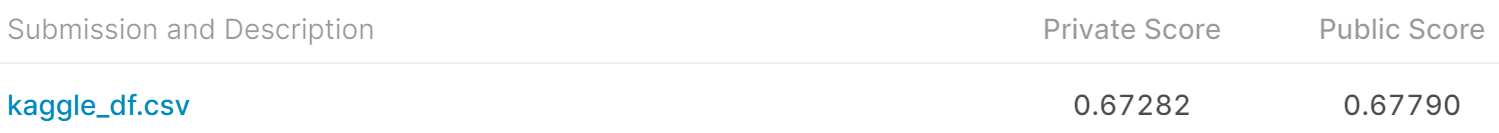

# Cost-Benefit Analysis
***
## Cost
The spraying agent used is primarily Zenivex and it is applied through Ultra Low Volume (ULV) treatment process. Truck-mounted foggers dispense very fine aerosol droplets that stay aloft and kill flying mosquitoes on contact. The mist of microscopic droplets or treatment is airborne and is not intended to leave significant residues, and flying mosquitoes are killed by contact with the treatment. Mosquito treatments are done at night when most
mosquitoes are flying and traffic is minimal.

In Chicago, the spraying amount is [1.5 fluid ounces per acre](https://www.chicago.gov/content/dam/city/depts/cdph/Mosquito-Borne-Diseases/Zenivex.pdf). The spray machines are electric and mounted on the back of pickup trucks, and the applicator drives the vehicle in the area to be sprayed. The Chicago Department of Public Health (CDPH) usually conducts spraying from [dusk to 1am] (https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_living/news/2021/august/city-to-spray-insecticide-wednesday-to-kill-mosquitoes.html) and trucks travel at a [speed of 10 to 15 miles per hour](https://www.cmmcp.org/services/faq/how-do-you-spray). 

The cost of the Zenivex E4 solutions (pricing data is from 2015) is at [USD79 per gallon for 275 gallons (1041 litres) of Zenivex E4](http://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/2015%20zenivex%20pricing%20brochure.pdf). According to the Zenivex brochure, the cost to spray per acre can be calculated to be **\\$0.93/acre** in 2015, assuming a 3% inflation rate, it would cost about **\\$1.16/acre** in 2022.

The city of Chicago is about [145,863 acres](https://www.census.gov/quickfacts/fact/table/chicagocityillinois/POP010220)

Given that the lifespan of the Culex species is between 2 weeks to 4 months (stated in the previous notebook), the most comprehensive spraying regime would involve spraying every 2 weeks every year at a cost of **$1,015,206**.

In [43]:
# zenivex required per city of chicago in ounces
spray_cost_chicago = 1.16 * 145863

# cost if spraying is conducted every 2 weeks from may-oct (summer-early fall, weeks 20-40)
cost_year = round(spray_cost_chicago * (20/2),2)

print(f'The cost of spraying per year is ${cost_year:,}. for fortnightly spraying')

The cost of spraying per year is $1,692,010.8. for fortnightly spraying


## Productivity Gains From Prevention of WNV and its associated diseases

The WNV causes illnesses such as fever, Meningitis, Encephalitis and Acute Flaccid Paralysis.

Based on [studies](https://www.ajtmh.org/view/journals/tpmd/90/3/article-p402.xml), the productivity losses from patients hospitalized with the diseases in 2012 for the above diseases are as follows (assuming 3% inflation rate, the figures below are costs in 2022 prices):


| Disease | Lost Productivity ($) |
|:---:|:---:|
| Fever | 733 |
| Meningitis | 919 |
| Encephalitis | 71,546 |
| Acute Flaccid Paralysis | 16,607 |


[60 cases of WNV were reported in 2012](https://www.chicago.gov/content/dam/city/depts/cdph/statistics_and_reports/CDInfo_2013_JULY_WNV.pdf), and we will use this number as a basis for annual reported cases as we were unable to obtain longitudinal data on WNV case in Chicago. According to the [CDC](https://www.cdc.gov/westnile/symptoms/index.html#:~:text=About%201%20in%205%20people,symptoms%20in%20a%20few%20people.), 1 in 5 people will develop fever and 1 in 150 people will develop more severe illness. 


This means that:
* 12 people will develop fever.
* 1 person will develop more severe illnesses (we will use the maximum productivity loss (i.e. Encephalitis)) 

For maximum benefit, there will be no cases for WNV and we will reap **$80,342** of productivity gains.

In [43]:
total_cost = (12*733) + (1*71546)
print(f'The maximum productivity gain from ZERO WNV cases is ${total_cost:,}')

The maximum productivity gain from ZERO WNV cases is $80,342


### Reduced Periodicity of Spray for Cost Effectiveness

As the cost of implementing a fortnightly spray routine is much larger than the productivity gains, it is not recommended to conduct a spray routine. In addition, according to our study, spraying does not seem to have an effect on reducing the number of WNV cases in Chicago.

From notebook 1, we have also juxtaposed the number of mosquitoes trapped and the WNV cases with the weeks that spraying was conducted and observed that although the number of mosquitoes trapped decreased in 2013, the cases continued to increase even though spraying was done weekly over a 5 week period (weeks 32-36). Therefore, even if we adopt a reduced periodicity of spraying to make it more cost-effective, there is evidence that it may not be effective.

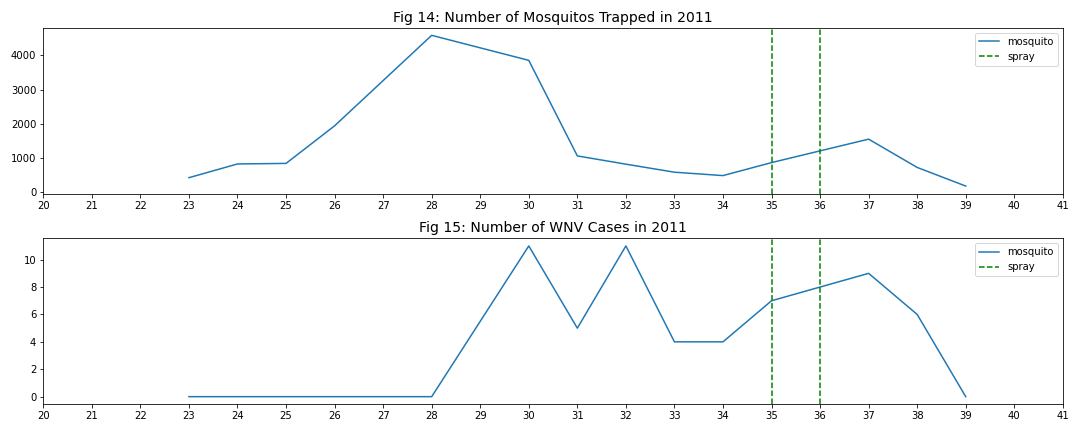

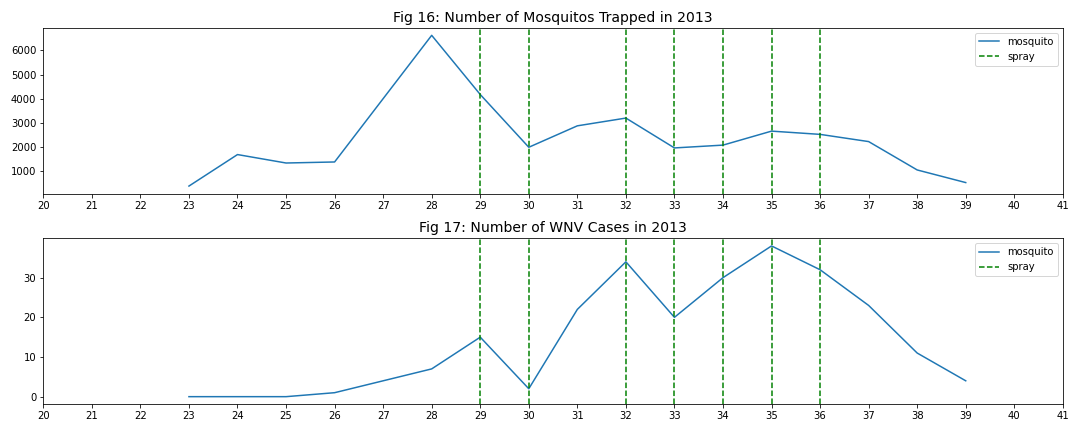

### Post-Spraying Outcomes in 2012 and 2014


Using our selected prediction model, we plotted the locations of the WNV cases in 2012 and 2014 to examine the outcomes of spraying in 2011 and 2014. From the 2 plots below, we can make the following observations:

* Almost all sprayed areas with WNV cases in the previous year showed re-emergence of WNV in the same location

* New cases emerged in 2014 from the previously sprayed locations in 2013. 

* There are large clusters that persisted from 2011 to 2014 on the upper left hand corner.

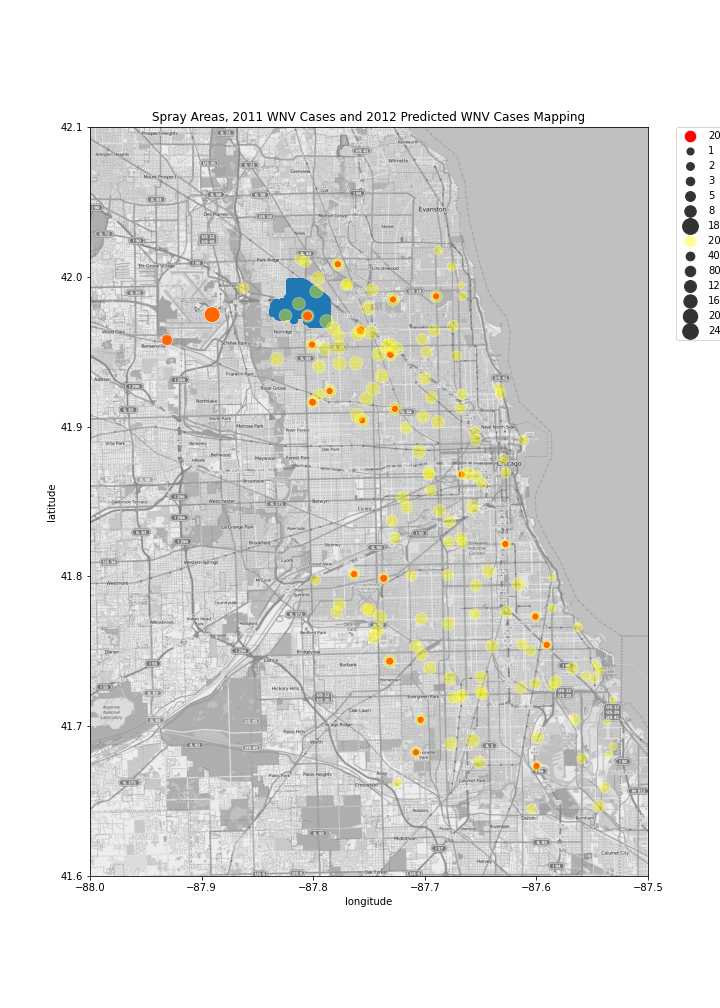

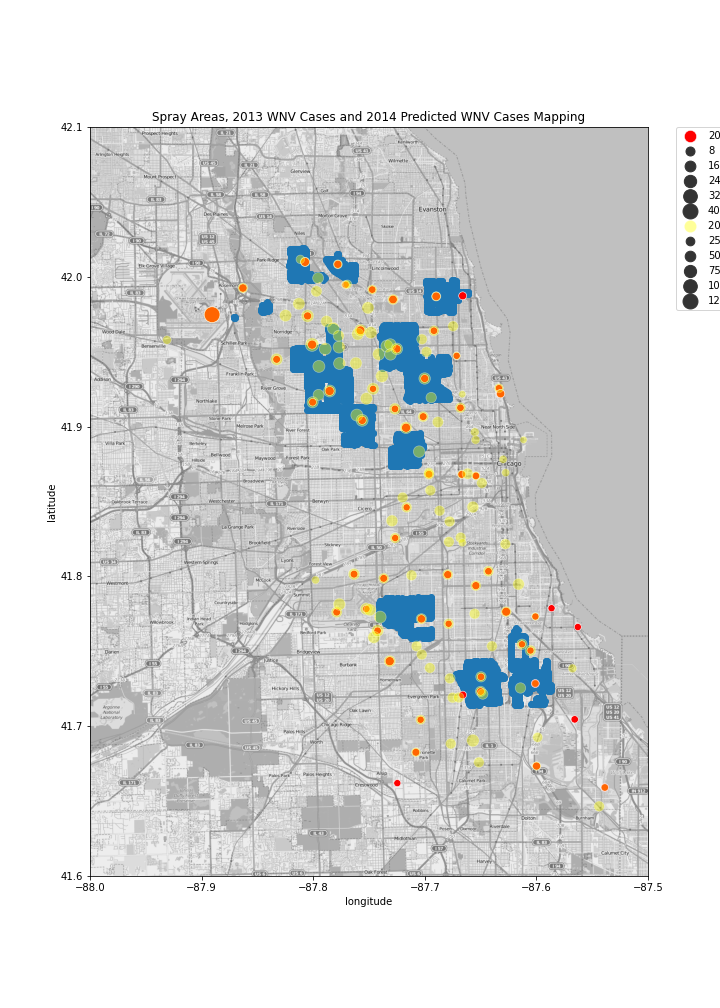

# Conclusion

We have built a prediction model to predict the number and locations of WNV cases in 2008, 2010, 2012 & 2014. The model does not directly help in eradicating the virus per se, but it informs us on the important features that may affect presence of the virus, which in this study are primarily weather features, which we have little to no control over.

We have also established that the desired outcome of decreasing the presence of the virus via spraying was not met as the WNV cases did not decrease after spraying and virus re-emergence was observed the following year as well. We recommend looking at other factors and solutions to control the virus.


## Recommendations

* Targeted Spraying: Instead of investing a large sum of money to conduct spraying on the entire city, better results may be obtained by focusing on larger clusters and conducting more intense spraying activities in those locations

* Change of Spray Period: From notebook 1, we notice that there is a build-up of WNV cases from week 27 - week 40 whereas spraying efforts in 2011 and 2013 happened **during** this period. A more effective solution might be to conduct spraying at week 25 (2 weeks before the build-up) to reduce mosquito activity in the following weeks

* Citizen Education: Conduct outreach and education efforts to inform citizens on the best practices to prevent mosquito breeding, periods of 'mosquito season' and the measures to prevent getting bitten

* Conduct enforcement checks